In [30]:
import pandas as pd
from transformers import BertTokenizer, BertModel
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import numpy as np
from sentence_transformers import SentenceTransformer, util
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from community import community_louvain
import networkx as nx
import matplotlib.pyplot as plt

# Problem

In deep learning and machine learning, there are multiple ways to solve the same problem. For NLP and LLM modeling, quantifying the semantic similarity of sentences is an important challenge to unlock meaning in a text corpus. This notebook compares techniques for characterizing the semantic similarity of sentences. Then, the Louvain, Graph-based community detection algorithm was applied to measure and compare clustering in the results.

# Data

The source text for this study was pulled from the NewsAPI public api, using the search term "fusion energy", and then output into a csv file with 59 unique, matching articles spanning 2020 - 2024. By utilizing NewsAPI, this limited the numner of retrieved articles to the channels that NewsAPI has access to, which may not be representative of all news sources. Additionally, the search term "fusion energy" may not be representative of the entire field of fusion energy research, as it may not include all relevant articles.

Below is a snippet of the csv with the main text columns. Only the 'description' column was used for the analysis. The description column was cleaned to remove extra spacing and Nans. Each article was assigned a unique ID.

In [ ]:
news1 = pd.read_csv('news.csv')
news1['description'] = news1['description'].astype(str)
news1['description'] = news1['description'].replace(r'^\s*$', np.nan, regex=True)

news2 = news1.dropna(subset=['description']) 
news3 = news2[news2['description'].str.lower() != 'nan'].reset_index(drop=True).reset_index()
news4 = news3[['description', 'content']].reset_index().rename(columns={'index': 'id'})
news4.head()

,id,description,content
0,0,Scientists in the UK have forged 5.5 tonnes of...,Scientists in the UK have forged 5.5 tonnes of...
1,1,"If advanced civilizations are out there, here’...",<ul><li>If fusion energy is a must-have for ad...
2,2,Researchers in China have used a novel approac...,Yahoo is using AI to generate takeaways from t...
3,3,There's a growing sense that developing practi...,The way scientists think about fusion changed ...
4,4,The fusion power plant would go live in the ne...,"Commonwealth Fusion Systems (CFS), a company w..."
5,5,Pokémon GO is adding Black Kyurem and White Ky...,Black Kyurem and White Kyurem are coming to Po...
6,6,La tecnología detrás de este avance ha batido ...,Corea del Sur ha alcanzado un hito impresionan...
7,7,Psychic Predictions 2024; News Items: Space Ex...,Psychic Predictions 2024News Items: Space Expl...
8,8,Even once researchers can reliably get more po...,Inside the target chamber at the National Igni...
9,9,Niantic and The Pokemon Company International ...,Niantic and The Pokemon Company International ...


# Methodology

The following models were used: Spacy vector embedding NLP, Sentence Transformers deep learning, Gensim_word2vec NLP, nltkwordnet NLP, BERT base deep learning, and RoBERTa deep learning. For each model, the results were output as cosine similarity matrices.Networkx graphs were generated on the matrices, and then the Louvain community detection algorithm was applied to the graphs for clustering analysis. 

The graphs of each model are displayed below. In building the graphs, the same threshold value of 0.5 was applied to the pageranks of sentences in each model. Pagerank is a rapid algorithm for measureing the centrality of nodes in a network. Edges with a pagerank below 0.5 were pruned from the graph. The size of each node is determined by pagerank. The color of each node is determined by its community membership.

In [37]:
# Graph-based clustering and plotting function
def process_graph(G, news_df, title="Graph Visualization"):
    """
    Process the given graph to detect Louvain communities, calculate PageRank, and return a DataFrame.

    Args:
        G (networkx.Graph): The input graph.
        news_df (pd.DataFrame): DataFrame containing sentence descriptions with 'id' and 'description'.
        title (str): Title for the graph visualization.

    Returns:
        pd.DataFrame: DataFrame with all sentences, PageRank, and community IDs.
    """
    # Step 1: Detect Louvain Communities
    communities = community_louvain.best_partition(G, weight='weight')
    community_ids = set(communities.values())
    community_colors = {cid: plt.cm.tab10(i % 10) for i, cid in enumerate(community_ids)}
    node_colors = [community_colors[communities[node]] for node in G.nodes]

    # Step 2: Calculate PageRank
    pagerank_scores = nx.pagerank(G, weight='weight')

    # Normalize PageRank scores for node sizing
    pagerank_min = min(pagerank_scores.values())
    pagerank_max = max(pagerank_scores.values())
    node_sizes = [
        500 + 3000 * (pagerank_scores[node] - pagerank_min) / (pagerank_max - pagerank_min)
        for node in G.nodes
    ]

    # Step 3: Plot the Graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,  # Color nodes by community
        node_size=node_sizes,    # Size nodes by PageRank
        font_size=10,
        edge_color="gray",
        alpha=0.8
    )
    plt.title(title)
    plt.show()

    # Step 4: Map Nodes to Sentence IDs
    graph_nodes = list(G.nodes())
    sentence_ids = news_df.index.tolist()
    node_to_sentence_id = {node: sentence_ids[i] for i, node in enumerate(graph_nodes)}

    # Map PageRank and Communities to Sentence IDs
    pagerank_with_sentence_ids = {node_to_sentence_id[node]: score for node, score in pagerank_scores.items()}
    community_with_sentence_ids = {node_to_sentence_id[node]: communities[node] for node in communities}

    # Step 5: Create DataFrame for All Sentences
    all_sentence_ids = list(node_to_sentence_id.values())
    df = pd.DataFrame({
        'id': all_sentence_ids,
        'description': [news_df.loc[sid, 'description'] for sid in all_sentence_ids],
        'pagerank': [pagerank_with_sentence_ids[sid] for sid in all_sentence_ids],
        'community_id': [community_with_sentence_ids[sid] for sid in all_sentence_ids]
    })
    return df

# Results

In [38]:
# Load models
st_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # Sentence Transformers
nlp = spacy.load('en_core_web_sm')  # SpaCy

# Compute Embeddings and Similarities
descriptions = news4['description'].tolist()
st_embeddings = st_model.encode(descriptions)  # SentenceTransformer embeddings
spacy_embeddings = [nlp(desc).vector for desc in descriptions]  # SpaCy embeddings

# Compute Pairwise Similarities
st_similarities = cosine_similarity(st_embeddings)
spacy_similarities = cosine_similarity(spacy_embeddings)

# Store Results in DataFrame
results = []
for i, desc in enumerate(descriptions):
    st_sim = st_similarities[i, :]  # All similarities for this sentence (Sentence Transformers)
    spacy_sim = spacy_similarities[i, :]  # All similarities for this sentence (SpaCy)

    # Store average similarity as a metric
    results.append({
        'id': news4.loc[i, 'id'],
        'description': desc,
        'st_similarity_avg': np.mean(st_sim),
        'spacy_similarity_avg': np.mean(spacy_sim)
    })

result_df = pd.DataFrame(results)

# Run Clustering on Sentence Transformers Embeddings
n_clusters = 3  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
result_df['cluster_id_kmeans'] = kmeans.fit_predict(st_embeddings)

agg_cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=6.9)
result_df['cluster_id_agglom'] = agg_cluster.fit_predict(st_embeddings)

dbscan = DBSCAN(eps=5.5, min_samples=2)
result_df['cluster_id_dbscan'] = dbscan.fit_predict(st_embeddings)

## Spacy Embeddings

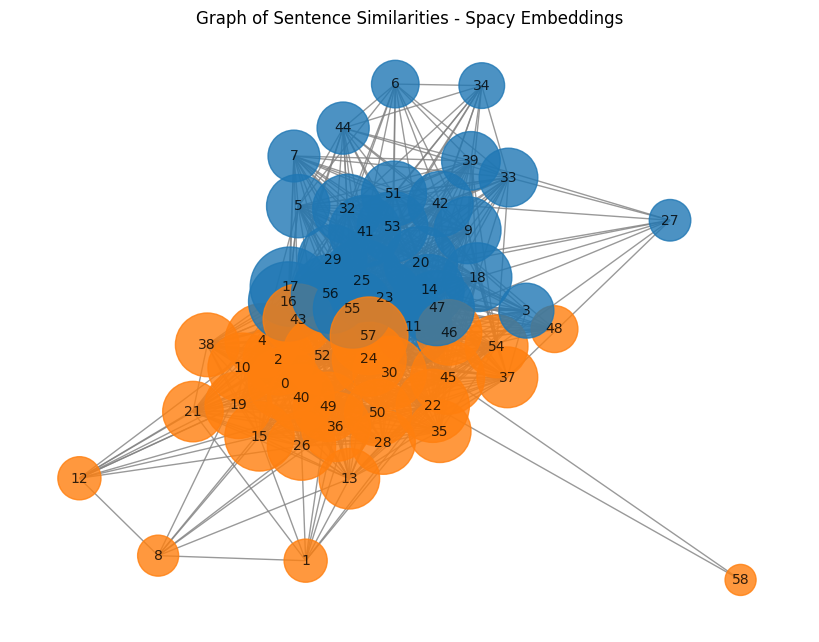

In [39]:
threshold = 0.5  # Filter edges with similarity below this threshold
G = nx.Graph()

# Add nodes and edges with weights
num_sentences = len(spacy_similarities)
for i in range(num_sentences):
    for j in range(i + 1, num_sentences):  # Avoid self-loops and duplicate edges
        similarity = spacy_similarities[i, j]
        if similarity >= threshold:  # Filter weak similarities
            G.add_edge(i, j, weight=similarity)

title = "Graph of Sentence Similarities - Spacy Embeddings"
full_df_spacyvector = process_graph(G, news4, title=title)

## Sentence Transformers

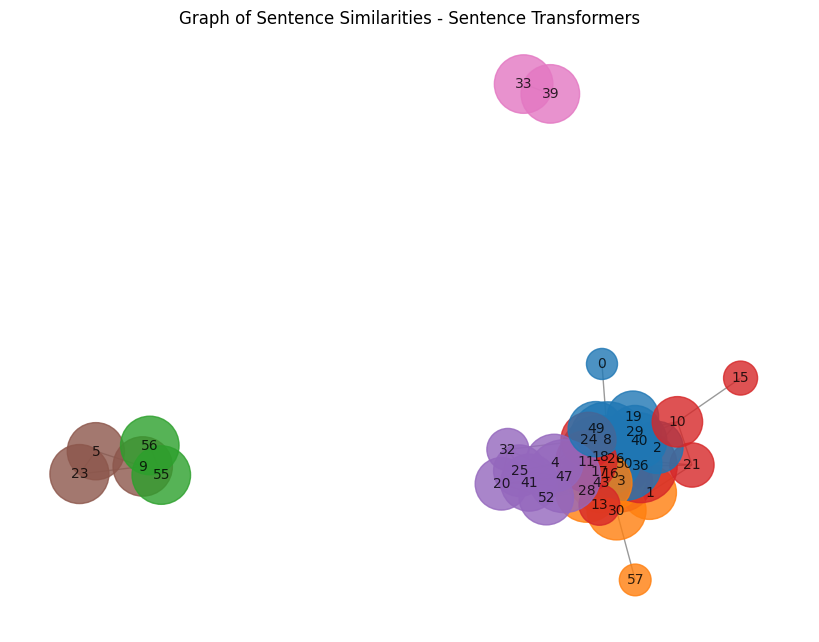

In [40]:
threshold = 0.5  # Filter edges with similarity below this threshold
G = nx.Graph()

num_sentences = len(st_similarities)
for i in range(num_sentences):
    for j in range(i + 1, num_sentences):  # Avoid self-loops and duplicate edges
        similarity = st_similarities[i, j]
        if similarity >= threshold:  # Filter weak similarities
            G.add_edge(i, j, weight=similarity)

title = "Graph of Sentence Similarities - Sentence Transformers"
full_df_sentencetransformers = process_graph(G, news4, title=title)

## Gensim Word2Vec

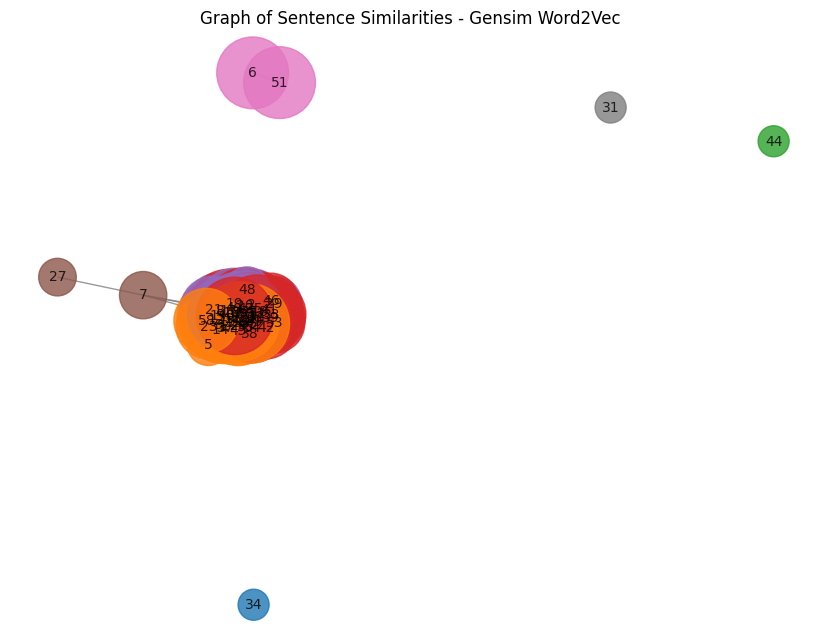

In [41]:
from gensim.models import KeyedVectors
from gensim.similarities import SoftCosineSimilarity
from gensim import corpora
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

from gensim.models import Word2Vec

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

news4['description'] = news4['description'].astype(str).fillna('')
descriptions = news4['description'].tolist()
tokenized_descriptions = [desc.split() for desc in descriptions]

# Filter tokens not in the vocabulary of the Word2Vec model
filtered_descriptions = [[word for word in tokens if word in model.key_to_index] for tokens in tokenized_descriptions]

# Compute pairwise similarities
# Initialize similarity matrix
num_descriptions = len(filtered_descriptions)
similarity_matrix = np.zeros((num_descriptions, num_descriptions))

for i in range(num_descriptions):
    for j in range(i, num_descriptions):  
        if filtered_descriptions[i] and filtered_descriptions[j]:  # Ensure both sentences are not empty
            similarity = model.n_similarity(filtered_descriptions[i], filtered_descriptions[j])
        else:
            similarity = 0  # If either description is empty after filtering
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity  # Fill symmetric value

# Create a DataFrame for visualization
similarity_df = pd.DataFrame(similarity_matrix, columns=news4['id'], index=news4['id'])

threshold = 0.5
G = nx.Graph()

for node in similarity_df.index:
    G.add_node(node)

for i, row in similarity_df.iterrows():
    for j, similarity in row.items():
        if i != j and similarity >= threshold:  # Avoid self-loops
            G.add_edge(i, j, weight=similarity)

title = "Graph of Sentence Similarities - Gensim Word2Vec"
full_df_gensim_word2vec = process_graph(G, news4, title=title)

## NLTK Wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/chjonte97/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


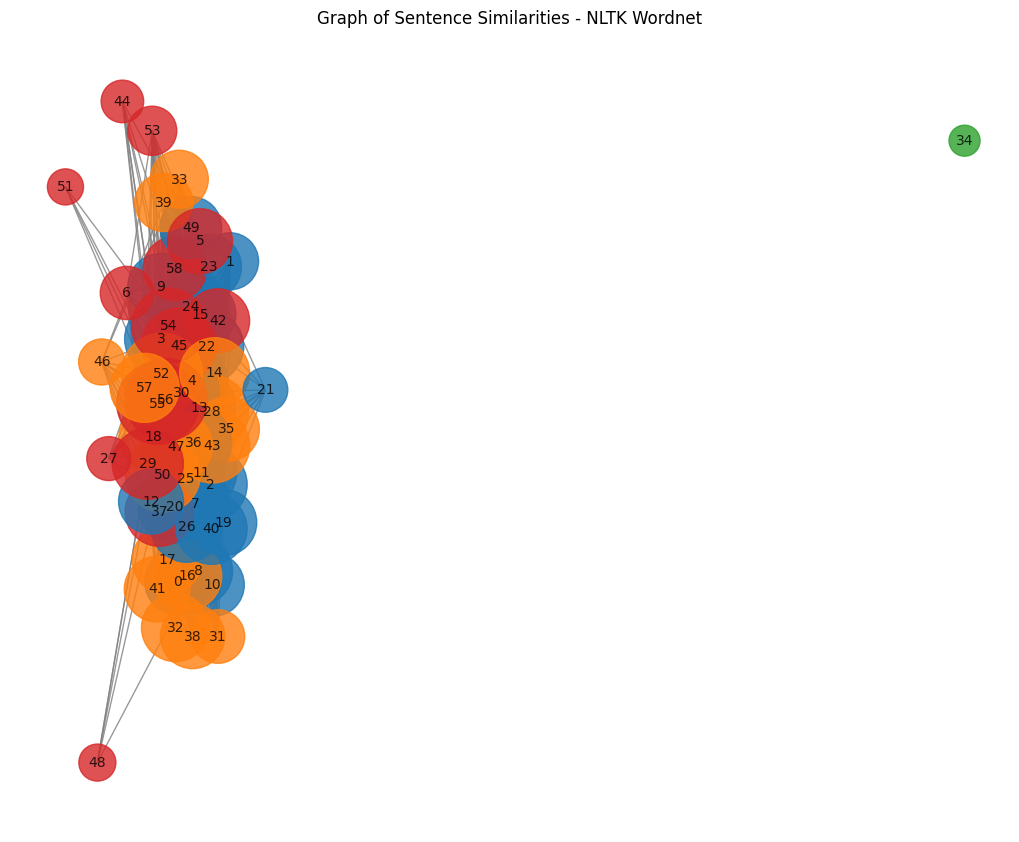

In [18]:
import nltk
from nltk.corpus import wordnet as wn
from itertools import product
nltk.download('wordnet')

# Define the similarity function using WordNet
def sentence_similarity(sentence1, sentence2):
    sentence1_synsets = [wn.synsets(word) for word in sentence1.split()]
    sentence2_synsets = [wn.synsets(word) for word in sentence2.split()]

    max_similarities = []
    for syn1 in sentence1_synsets:
        if syn1:  # Ensure synset exists
            max_similarity = max([syn1[0].wup_similarity(syn2[0]) or 0 for syn2 in sentence2_synsets if syn2], default=0)
            max_similarities.append(max_similarity)

    return sum(max_similarities) / len(max_similarities) if max_similarities else 0

# Compute Pairwise Similarity Matrix
descriptions = news4['description'].tolist()
num_descriptions = len(descriptions)
similarity_matrix = np.zeros((num_descriptions, num_descriptions))

for i in range(num_descriptions):
    for j in range(i, num_descriptions):  # Avoid redundant calculations
        similarity = sentence_similarity(descriptions[i], descriptions[j])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity  # Symmetric matrix

threshold = 0.5  # Set similarity threshold for edges
G = nx.Graph()

# Add nodes and edges
for i in range(num_descriptions):
    G.add_node(i)  # Add each sentence as a node
    for j in range(i + 1, num_descriptions):  # Avoid self-loops and duplicate edges
        if similarity_matrix[i, j] >= threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

title = "Graph of Sentence Similarities - NLTK Wordnet"
full_df_nltkwordnet = process_graph(G, news4, title=title)

## BERT - Base Model

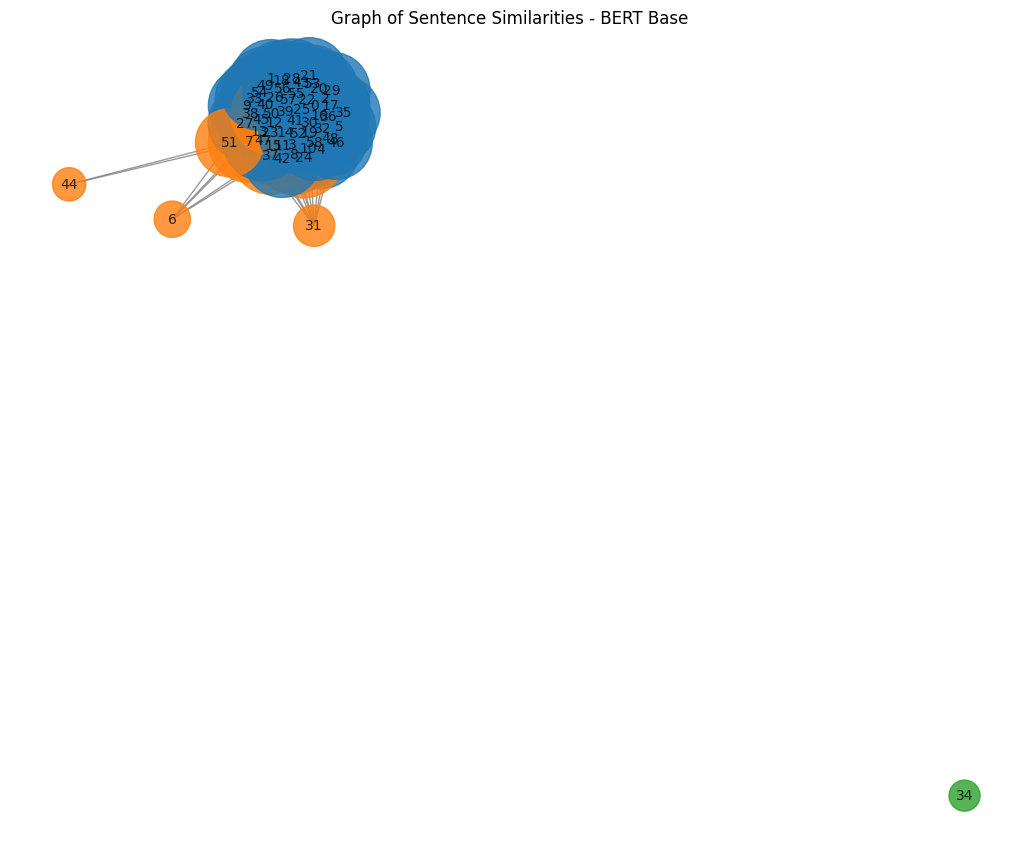

In [20]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

# Define function to get sentence embeddings
def get_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Generate embeddings for all descriptions
news4 = news4.dropna(subset=['description']).reset_index(drop=True)  # Ensure no NaN descriptions
descriptions = news4['description'].tolist()
embeddings = [get_embedding(desc) for desc in descriptions]  # List of sentence embeddings

# Compute cosine similarity matrix
cosim_matrix = cosine_similarity(np.vstack(embeddings))  # Cosine similarity between all embeddings

threshold = 0.5  # Filter edges below this similarity threshold
G = nx.Graph()

# Add nodes and edges
for i in range(len(cosim_matrix)):
    G.add_node(i)  # Add each sentence as a node
    for j in range(i + 1, len(cosim_matrix)):  # Avoid self-loops and duplicate edges
        if cosim_matrix[i, j] >= threshold:
            G.add_edge(i, j, weight=cosim_matrix[i, j])

title = "Graph of Sentence Similarities - BERT Base"
full_df_bertbase = process_graph(G, news4, title=title)

## BERT - Roberta Model

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


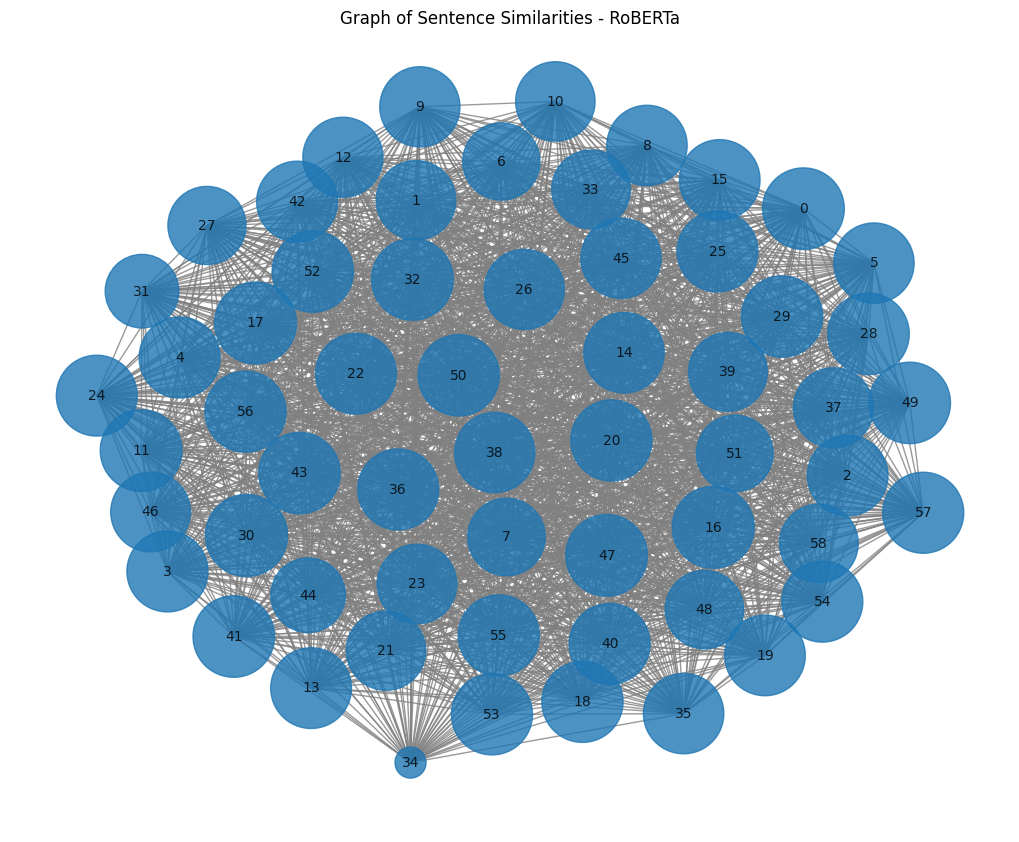

In [22]:
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

# Load Roberta Tokenizer and Model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Define Mean Pooling Function
def mean_pooling(outputs, attention_mask):
    token_embeddings = outputs.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Generate Embeddings for Descriptions
descriptions = news4['description'].tolist()
embeddings = []

for desc in descriptions:
    # Tokenize description
    inputs = tokenizer(desc, return_tensors="pt", truncation=True, max_length=512, padding=True)
    outputs = model(**inputs)

    # Apply mean pooling
    embedding = mean_pooling(outputs, inputs['attention_mask']).detach().numpy()
    embeddings.append(embedding)

# Convert embeddings to a NumPy array
embeddings = np.vstack(embeddings)

# Compute Cosine Similarity Matrix
cosim_matrix = cosine_similarity(embeddings)

# Build the Graph
threshold = 0.5  # Set similarity threshold for edges
G = nx.Graph()

# Add nodes and edges
for i in range(len(cosim_matrix)):
    G.add_node(i)  # Add each sentence as a node
    for j in range(i + 1, len(cosim_matrix)):  # Avoid self-loops and duplicate edges
        if cosim_matrix[i, j] >= threshold:
            G.add_edge(i, j, weight=cosim_matrix[i, j])

title = "Graph of Sentence Similarities - RoBERTa"
full_df_roberta = process_graph(G, news4, title=title)

In [23]:
dfs = [full_df_spacyvector, full_df_sentencetransformers, full_df_gensim_word2vec, full_df_nltkwordnet, full_df_bertbase, full_df_roberta]


Below is a snippet of the graph clustering results for each model:

In [24]:
full_df_spacyvector.head()

,id,description,pagerank,community_id
0,0,Scientists in the UK have forged 5.5 tonnes of...,0.020899,0
1,1,"If advanced civilizations are out there, here’...",0.020115,0
2,2,Researchers in China have used a novel approac...,0.021717,0
3,3,There's a growing sense that developing practi...,0.018987,0
4,4,The fusion power plant would go live in the ne...,0.023389,0


In [25]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

dfs = [full_df_spacyvector, full_df_sentencetransformers, full_df_gensim_word2vec, full_df_nltkwordnet, full_df_bertbase, full_df_roberta]
model_names = ['spacyvector', 'sentencetransformers', 'gensim_word2vec', 'nltkwordnet', 'bertbase', 'roberta']

Combine DataFrames for Comparison
combined_df = pd.concat(
    [df[['id', 'pagerank', 'community_id']].rename(
        columns={'pagerank': f'pagerank_{name}', 'community_id': f'community_id_{name}'}
    ) for df, name in zip(dfs, model_names)],
    axis=1
)

combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

# Compare PageRank Across Models
pagerank_stats = combined_df.describe().filter(like='pagerank')

# Count Unique Communities Across Models
community_counts = {name: df['community_id'].nunique() for df, name in zip(dfs, model_names)}

In [27]:
def summarize_all_communities(df, model_name=None):
    """
    Summarize high-level statistics across all communities.

    Args:
        df (pd.DataFrame): DataFrame containing 'community_id' and 'description'.
        model_name (str): Model name for labeling.

    Returns:
        pd.DataFrame: Summary of all communities with total and average stats.
    """
    # Determine correct community ID column
    possible_columns = [f'community_id_{model_name}', 'community_id']
    community_column = next((col for col in possible_columns if col in df.columns), None)

    if not community_column:
        raise KeyError(f"Community column not found. Checked: {possible_columns}")

    # Calculate stats
    total_sentence_count = len(df)
    total_community_count = df[community_column].nunique()
    average_community_size = total_sentence_count / total_community_count

    # Create summary DataFrame
    summary = pd.DataFrame([{
        'model': model_name,
        'total_sentence_count': total_sentence_count,
        'total_community_count': total_community_count,
        'average_community_size': average_community_size
    }])
    return summary

In [28]:
all_community_summary_spacyvector = summarize_all_communities(full_df_spacyvector, model_name='spacyvector')
all_community_summary_sentencetransformers = summarize_all_communities(full_df_sentencetransformers, model_name='sentencetransformers')
all_community_summary_word2vec = summarize_all_communities(full_df_gensim_word2vec, model_name='word2vec')
all_community_summary_nltkwordnet= summarize_all_communities(full_df_nltkwordnet, model_name='nltkwordnet')
all_community_summary_bertbase = summarize_all_communities(full_df_bertbase, model_name='bertbase')
all_community_summary_roberta = summarize_all_communities(full_df_roberta, model_name='roberta')

all_community_summary_dfs = [all_community_summary_spacyvector, all_community_summary_sentencetransformers, all_community_summary_word2vec, all_community_summary_nltkwordnet, all_community_summary_bertbase, all_community_summary_roberta]
all_community_summary_dfs2 = pd.concat(all_community_summary_dfs)

# Discussion

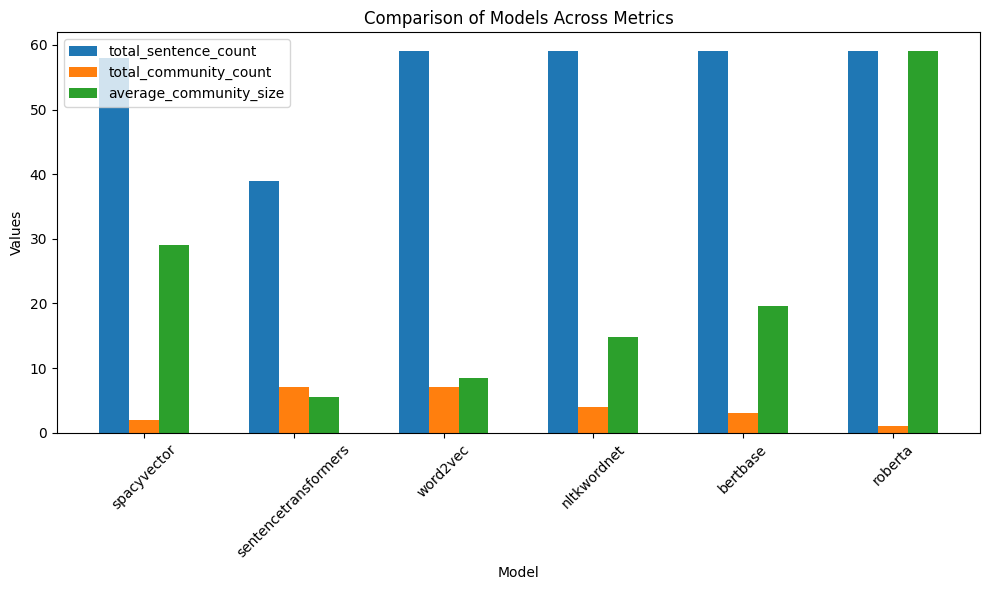

In [29]:
# Prepare data
categories = ['total_sentence_count', 'total_community_count', 'average_community_size']
x = np.arange(len(all_community_summary_dfs2['model']))  # the label locations
width = 0.2  # the width of the bars

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for each category
for i, category in enumerate(categories):
    ax.bar(x + i * width, all_community_summary_dfs2[category], width, label=category)

# Add labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Values')
ax.set_title('Comparison of Models Across Metrics')
ax.set_xticks(x + width, all_community_summary_dfs2['model'])
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The barcharts above show the comparison of models across metrics. The total sentence count is the total number of sentences in the dataset. The total community count is the total number of communities detected by the Louvain algorithm. The average community size is the average number of sentences in each community.

Sentence Transformers has the fewest sentences remaining after graph pruning, indicating a higher degree of clustering. Sentence Transformers also has the highest count of communities and lowest community size. Word2Vec has slightly fewer communities but its communities are larger due to more sentences remaining after graph pruning.

NLTK Wordnet and the BETR base model are the next similar pair in terms of community count, but NLTK Wordnet has slightly more communities and smaller community sizes.

The Roberta model has only 1 community, indicating a highly interconnected graph compared to all other models.

# Conclusions

In [339]:
def summarize_community_details(df, model_name=None):
    """
    Generate a summary of communities with one row per community.

    Args:
        df (pd.DataFrame): DataFrame containing 'community_id', 'pagerank', and 'description'.
        model_name (str): Name of the model for labeling in the summary.

    Returns:
        pd.DataFrame: A DataFrame with columns:
                      ['model', 'community_id', 'community_keywords', 
                       'community_average_pagerank', 'community_sentence_count']
    """
    # Determine the correct community ID column
    possible_columns = [f'community_id_{model_name}', 'community_id']
    community_column = next((col for col in possible_columns if col in df.columns), None)

    if not community_column:
        raise KeyError(f"Community column not found. Checked: {possible_columns}")

    # Group by `community_id` and calculate stats
    grouped = df.groupby(community_column).agg(
        community_sentence_count=('description', 'count'),
        community_average_pagerank=('pagerank', 'mean')
    ).reset_index()

    # Extract community keywords using TF-IDF
    def extract_keywords(descriptions):
        combined_text = " ".join(descriptions)
        vectorizer = TfidfVectorizer(max_features=5, stop_words='english')
        tfidf_matrix = vectorizer.fit_transform([combined_text])
        return ", ".join(vectorizer.get_feature_names_out())

    # Add keywords for each community
    grouped['community_keywords'] = grouped[community_column].apply(
        lambda cid: extract_keywords(df[df[community_column] == cid]['description'].tolist())
    )

    # Add model name
    grouped['model'] = model_name

    # Reorder columns
    grouped = grouped[['model', community_column, 'community_keywords', 
                       'community_average_pagerank', 'community_sentence_count']]

    # Rename `community_id` column for consistency
    grouped.rename(columns={community_column: 'community_id'}, inplace=True)

    return grouped

In [347]:
community_details_spacyvector = summarize_community_details(full_df_spacyvector, model_name='spacyvector')
community_details_sentencetransformers = summarize_community_details(full_df_sentencetransformers, model_name='sentencetransformers')
community_details_word2vec = summarize_community_details(full_df_gensim_word2vec, model_name='word2vec')
community_details_nltkwordnet= summarize_community_details(full_df_nltkwordnet, model_name='nltkwordnet')
community_details_bertbase = summarize_community_details(full_df_bertbase, model_name='bertbase')
community_details_roberta = summarize_community_details(full_df_roberta, model_name='roberta')

community_details_dfs = [community_details_spacyvector, community_details_sentencetransformers, community_details_word2vec, community_details_nltkwordnet, community_details_bertbase, community_details_roberta]
community_details_dfs2 = pd.concat(community_details_dfs)
community_details_dfs2

,model,community_id,community_keywords,community_average_pagerank,community_sentence_count
0,spacyvector,0,"electricity, fusion, megawatts, power, systems",0.014977,4
1,spacyvector,1,"2025, die, energy, fusion, nuclear",0.018044,25
2,spacyvector,2,"fusion, increased, nuclear, plant, power",0.017195,4
3,spacyvector,3,"energy, fusion, nuclear, power, virginia",0.016809,25
0,sentencetransformers,0,"energy, experiment, fusion, nuclear, time",0.027792,10
1,sentencetransformers,1,"26, doc, models, organised, said",0.025641,2
2,sentencetransformers,2,"energy, fusion, kyurem, nuclear, power",0.024938,14
3,sentencetransformers,3,"energy, fusion, nuclear, power, scale",0.024182,8
4,sentencetransformers,4,"2024, fusion, magazine, mon, physics",0.025641,3
5,sentencetransformers,5,"breakthrough, clean, energy, lasting, longer",0.025641,2


By extracting keywords using TfidfVectorizer, perhaps the most interesting conclusion of this study became apparent: the RoBERTa model was able to identify the most relevant keywords for each community, in my subjective opinion. This suggests that RoBERTa embeddings are more effective at capturing the semantic meaning of sentences, which is crucial for community detection and keyword extraction tasks. The other models, while still effective, may not be as robust in capturing the underlying semantics of the sentences. This highlights the importance of choosing the right model for the task at hand, as different models may excel in different areas based on their architecture and training data.

Overall, this usage of semantic sentence comparison was useful to show how the meaning and concepts within a text can be compared. But it did not assess sentiment or trends, this would be future work to evaluate changes in opinons about a topic over time.